In [2]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

def displayFrequencyResponse(b, a=[1], num=None, mag='log', new_figure=True, **kwargs):
    w, Hw = sig.freqz(b, a)
    H_amp = np.abs(Hw)
    H_phase = np.unwrap(np.angle(Hw, deg=True), period=360)
    if new_figure==True:
        if num is not None:
            plt.close(num)
        fig, [ax1, ax2] = plt.subplots(num=num, nrows=2)
    else :
        fig = plt.figure(num=num)
        ax1 = fig.axes[0]
        ax2 = fig.axes[1]
    
    if mag.lower()=='log':
        ax1.plot(w, 20*np.log10(H_amp), **kwargs)
        ax1.set_ylabel(r'$\left| H\left(\hat{\omega}\right)\right|$ (dB)')
    else:
        ax1.plot(w, H_amp, **kwargs)
        ax1.set_ylabel(r'$\left| H\left(\hat{\omega}\right)\right|$')

    ax1.set_xticks(np.linspace(0, 1, 6)*pi, [str(round(i,2))+r'$\pi$' for i in np.linspace(0, 1, 6)])
    ax1.set_xlabel(r'Digital Frekvens $\hat{\omega}$')

    ax1.set_xlim([0, pi])
    ax1.set_title(r'Frekvensrespons $H\left(\hat{\omega}\right)$')

    phaseResp, = ax2.plot(w, H_phase, **kwargs)

    ax2.set_xticks(np.linspace(0, 1, 6)*pi, [str(round(i,2))+r'$\pi$' for i in np.linspace(0, 1, 6)])
    ax2.set_xlabel(r'Digital Frekvens $\hat{\omega}$')
    ax2.set_ylabel(r'$\angle H\left(\hat{\omega}\right)$ (degrees)')

    if "label" in kwargs.keys():
        ax2.legend()
        ax1.legend()
    fig.tight_layout(pad=0.1, w_pad=1.0, h_pad=1.0)

%matplotlib ipympl

# Key points in filter design:


* **Symmetrical Impulse response: $h[n] = h[M-n-1]$**
    * Ensures ***linear phase response*** in passband: $\angle H(\hat{\omega}) = -\frac{M-1}{2}\cdot \hat{\omega}$
    * All frequency components time-shifted equally $\rightarrow$ signal shape is preserved

* Odd numbered filter lenght $M$ is often desirable:
    * The ***group delay*** $D(\hat{\omega}) = - \frac{d \angle H(\hat{\omega})}{d\hat{\omega}}=\frac{M-1}{2}$ is an integer.
    * All frequency components being delayed by an integer number of samples makes it easy to align differently filtered signals with $0$ relative phase difference.

## Example:
* Find a *general expression* frequency response $H(\hat{\omega})$ for a $M=5$-tap FIR filter with symmetrical impulse response $h[n] = h[4-n]$, where the specific values of each sample $h[n]$ is not determined:

* Can we infer a further generalization which holds for *any* odd-length filter?

# FIR filter general form of frequency response

$$\large H(\hat{\omega}) = \left( h\left[D \right] + 2\sum_{n=1}^{D} h\left[n + D\right] \cdot \cos \left(n \cdot \hat{\omega} \right) \right) \cdot e^{-j\hat{\omega} \cdot D}, \ \ \ D = \frac{M-1}{2}$$

* Not dissimilar to fourier series reconstruction, except we're now constructing a continuous *frequency-domain* function from discrete *time-domain* samples $h[n]$


* For any given frequency $\hat{\omega}$, the response contribution from each sample in the impulse response is *linearly independent*. 

# Optimal FIR filter design

* Define an error function:

$$ E\left(\vec{h}\right) = \max\left( H_{\text{ideal}}(\hat{\omega}) - H(\hat{\omega})\right)^2$$

* Find the vector  $\vec{h} = \left[h[0], h[1], \ldots , h[M-1] \right]^T$ which minimizes the error function $E\left(\vec{h}\right)$
    * Similar enough to "conventional" least squares problems
    * [Remez Exchange Algorithm](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/generated/scipy.signal.remez.html) especially designed to solve this optimization problem

* Enables designing FIR filters which meets design specifications, using a smaller number of filter taps $M$ compared to the window method.
    * Downside: computationally intensive, and may fail to find the optimal solution

# Comparing windowed FIR filters to optimal FIR filters

<img src="figures/remez_exchange.svg" style="width: 80%; margin-left: 50px" />

# Optimal filters allow for separate weighing of different bands

<img src="figures/remez_relative_weights.svg" style="width: 80%; margin-left: 50px" />

#### Key insight:
* FIR filter design is an ***optimization problem***.
    * Find the vector $\vec{h} = \left[h[0], h[1], \ldots , h[M-1] \right]^T$ which minimizes som error function e.g. $E(\vec{h})$
    * Gradient descent can be used

#  [consider demo]

# 'Optimal' FIR-filters

* The Remez Exchange algorithm (aka. Parks-McClellan) is an algorithm which uses optimization techniques to find the optimal FIR filter $h[n]$.
    * 
* Included in the `scipy.signal` module through the function [`remez()`](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/generated/scipy.signal.remez.html)
* Vi bruker en rekke arrayer til å spesifisere *nøyaktig* hvordan vi ønsker at filteret skal være.
* Filteret returnerer det optimale filteret med gitt filterorden som er mest mulig likt kravene:
    * Alle de små "toppene" i stoppbåndet vil være nøyaktig like høye.
    * Passbånd rippel er like stor over hele passbåndet
    * Gir et filter med litt lavere filterorden enn et filter designet med vindusmetoden gitt samme krav til ytelse.


# Usage: Lowpassfilter

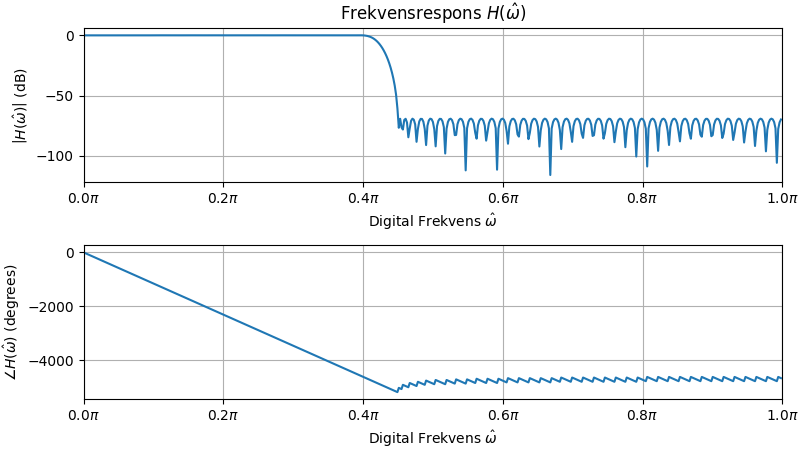

In [6]:
fs = 20_000       # Sample rate, Hz
w_pass = 4_000    # Desired cutoff frequency, Hz
w_stop = 4_500      # Width of transition from pass band to stop band, Hz
numtaps = 129      # Size of the FIR filter.

hn = sig.remez(numtaps,                                    # Lengde på impulsrespons = filterorden + 1
               [0, w_pass, w_stop, 0.5*fs],  # Alle 'kantfrekvensene' etter tur 
               [1, 0],                                     # Ønsket filtergain i de ulike båndene
               fs=fs,                                      # Samplingsfrekvens
               weight=[1, 10],                              # Relative weighing of error function in the two bands
               type='bandpass'                                           
              )

displayFrequencyResponse(b=hn)

# Usage: bandlimited differentiator

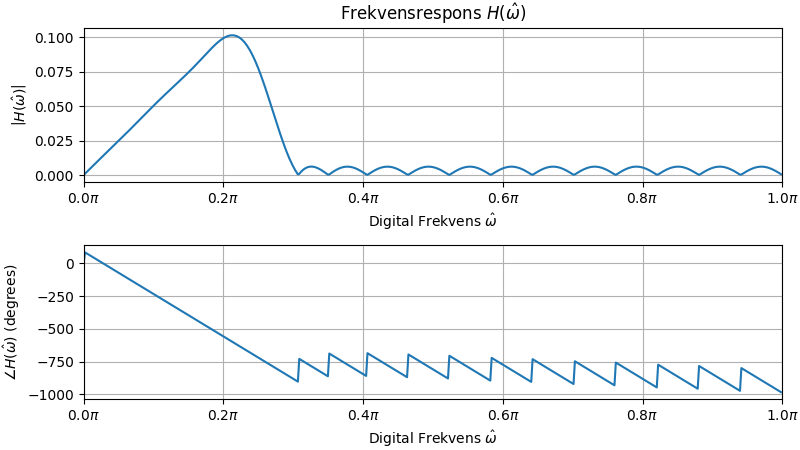

In [10]:
fs = 10_000         # Sample rate, Hz
w_pass = 1000     # Desired cutoff frequency, Hz
w_stop = 1500     # Width of transition from pass band to stop band, Hz
numtaps = 37      # Size of the FIR filter.

hn = sig.remez(numtaps,                                    # Lengde på impulsrespons = filterorden + 1
               [0, w_pass, w_stop, 0.5*fs],  # Alle 'kantfrekvensene' etter tur 
               [1, 0],                                     # Ønsket filtergain i de ulike båndene
               fs=fs,                                      # Samplingsfrekvens
               weight=[1, 1],                             # Vi "bryr oss" 10 ganger mer om rippel i passbånd 
                                                           # enn demping i stoppbånd
               type='differentiator'
              )

displayFrequencyResponse(b=hn, mag='lin')